# Vague d'impulsion

In [1]:
from pathlib import Path
from config import config
from insert_dam import insert_dam
from makeqinit_matplotlib import make_qinit
from setrun import setrun as make_data
from energy import compute_energies_masses, plot as plot_energy_mass
from make_tools import make_new, make_output

import rasterio
import topo_utils

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource

from clawpack.geoclaw import fgout_tools
from clawpack.geoclaw import fgmax_tools
from clawpack.geoclaw import topotools

## Loading DEM

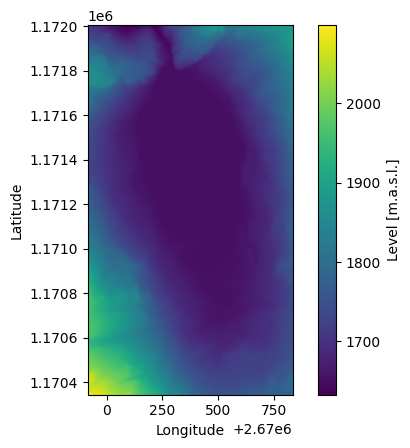

In [2]:
bbox = config["lower"]+config["upper"]
w, s, e, n = bbox
extent = w, e, s, n
x, y, Z = topo_utils.read_raster(config["base_bathymetry"],
                                 bbox,
                                 config["cell_size"])

plt.imshow(Z, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Hillshade

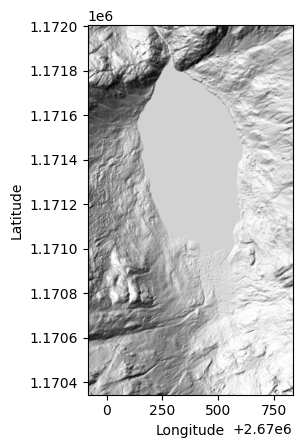

In [3]:
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(Z), cmap="gray", extent=extent)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

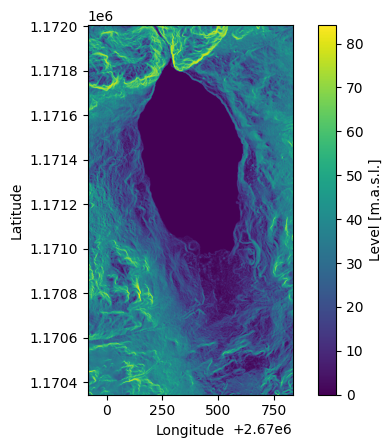

In [4]:
slope = np.sqrt(np.square(np.gradient(Z, config["cell_size"])).sum(axis=0))
slope = np.rad2deg(np.arctan(slope))
plt.imshow(slope, extent=extent)
plt.colorbar(label="Level [m.a.s.l.]")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## AVAC

Reading fgout grid info from 
    avac/_output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
    Reading  Frame 1 at t = 0  from outdir = /home/giboulot/Projects/TriftGeoClaw/avac/_output
    Reading  Frame 90 at t = 90  from outdir = /home/giboulot/Projects/TriftGeoClaw/avac/_output


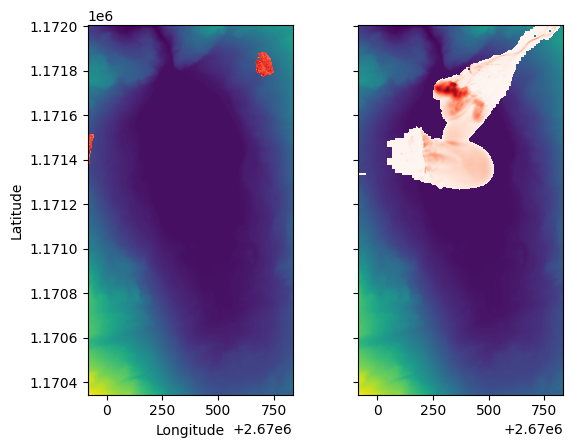

In [5]:
avac_fgout = fgout_tools.FGoutGrid(config["fgout_fgno"], config["AVAC_outdir"])
avac_fgout.read_fgout_grids_data()

avac_hinit = avac_fgout.read_frame(1).h
avac_hfinal = avac_fgout.read_frame(avac_fgout.nout).h

avac_hinit = np.where(avac_hinit>0, avac_hinit, np.nan)
avac_hfinal = np.where(avac_hfinal>0, avac_hfinal, np.nan)

fig, axes = plt.subplots(ncols=2, sharex="all", sharey="all")
for ax in axes:
    ax.imshow(Z, extent=extent)

axes[1].imshow(avac_hfinal.T, extent=extent, origin="lower", cmap="Reds")
axes[0].imshow(avac_hinit.T, extent=extent, origin="lower", cmap="Reds")

axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
plt.show()

## Insert dam

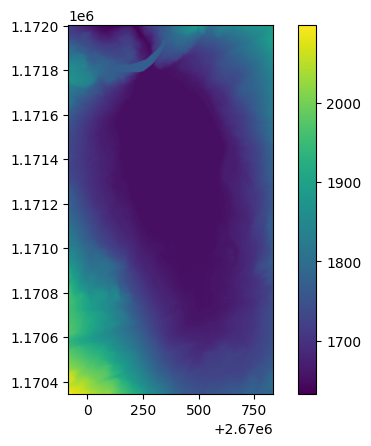

In [6]:
dams = topo_utils.read_poly(config["dams"])
Z = insert_dam(dams, config["dam_alts"], x, y, Z)

plt.imshow(Z, extent=extent)
plt.colorbar()
plt.show()

## Initial solution (lake)

Filling lake


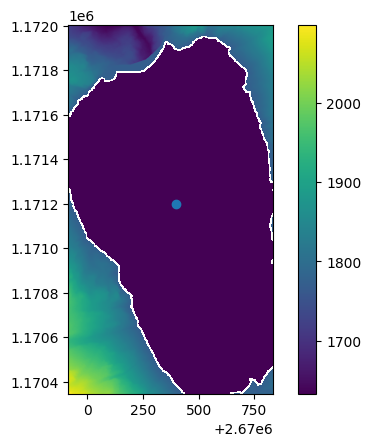

In [7]:
flood_seed = 2.67e6 + 400, 1.1712e6
x0, y0, eta0 = make_qinit(x, y, Z,
                          config["lake_alt"],
                          flood_seed=flood_seed,
                          dilation_radius=config["flood_dilation"])
plt.imshow(np.where(eta0>=Z, eta0, np.nan), extent=(x0.min(), x0.max(), y0.min(), y0.max()))
plt.imshow(np.where(eta0<Z, Z, np.nan), extent=(x0.min(), x0.max(), y0.min(), y0.max()))
plt.colorbar()
plt.scatter(*flood_seed)
plt.show()

## Exporting the DEMs for geoclaw

In [12]:
topo = topotools.Topography()
topo.x = x0
topo.y = np.sort(y0)
topo.Z = eta0
topo.write(config["qinit"][0], topo_type=1)  # There can be multiple qinit files

In [16]:
y

array([1172005.        , 1172002.99758745, 1172000.99517491,
       1171998.99276236, 1171996.99034982, 1171994.98793727,
       1171992.98552473, 1171990.98311218, 1171988.98069964,
       1171986.97828709, 1171984.97587455, 1171982.973462  ,
       1171980.97104946, 1171978.96863691, 1171976.96622437,
       1171974.96381182, 1171972.96139928, 1171970.95898673,
       1171968.95657419, 1171966.95416164, 1171964.9517491 ,
       1171962.94933655, 1171960.946924  , 1171958.94451146,
       1171956.94209891, 1171954.93968637, 1171952.93727382,
       1171950.93486128, 1171948.93244873, 1171946.93003619,
       1171944.92762364, 1171942.9252111 , 1171940.92279855,
       1171938.92038601, 1171936.91797346, 1171934.91556092,
       1171932.91314837, 1171930.91073583, 1171928.90832328,
       1171926.90591074, 1171924.90349819, 1171922.90108565,
       1171920.8986731 , 1171918.89626055, 1171916.89384801,
       1171914.89143546, 1171912.88902292, 1171910.88661037,
       1171908.88419783,

In [ ]:
topo = topotools.Topography()
topo.x = x
topo.y = np.sort(y)  # TODO
topo.Z = Z
topo.write(config["bathymetry"], topo_type=config["topo_type"])

## Make executable, data & output

In [10]:
if not Path("xgeoclaw").is_file():
    exit_code = make_new()
    assert exit_code ==1, "Compilation failed! See logs above."

In [13]:
make_data(AVAC_outdir=config["AVAC_outdir"])
make_output()

Reading fgout grid info from 
    /home/giboulot/Projects/TriftGeoClaw/avac/_output/fgout_grids.data
Reading input for fgno=1, point_style = 2 
Found fgout grid q_out_vars =  [1, 2, 3, 4]
Using this mapping to fgout variable names: 
      qmap =  {'h': 1, 'hu': 2, 'hv': 3, 'eta': 4, 'B': 5}
Coarsest cells size : 131.43, 138.33
Finest cells size : 2.05, 2.16


Makefile:71: warning: overriding recipe for target 'all'
/home/giboulot/Projects/TriftGeoClaw/claw/src/clawpack/clawutil/src/Makefile.common:323: warning: ignoring old recipe for target 'all'
Makefile:78: warning: overriding recipe for target 'data'
/home/giboulot/Projects/TriftGeoClaw/claw/src/clawpack/clawutil/src/Makefile.common:230: warning: ignoring old recipe for target 'data'


rm -f .output
python /home/giboulot/Projects/TriftGeoClaw/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py xgeoclaw                  _output                \
True None . False False None 
==> runclaw: Will take data from  /home/giboulot/Projects/TriftGeoClaw
==> runclaw: Will write output to  /home/giboulot/Projects/TriftGeoClaw/_output
==> runclaw: Removing all old fort/gauge files in  /home/giboulot/Projects/TriftGeoClaw/_output

==> Running with command:
    /home/giboulot/Projects/TriftGeoClaw/xgeoclaw
Reading data file: claw.data
         first 5 lines are comments and will be skipped
Reading data file: amr.data
         first 5 lines are comments and will be skipped
  
 Running amrclaw ...  
  
Reading data file: setprob.data
         first 5 lines are comments and will be skipped
Reading data file: /home/giboulot/Projects/TriftGeoClaw/avac/_output/fgout_grids.data
         first 5 lines are comments and will be skipped
 +++ q_out_vars: T T T T F F
 +++ nqout =          

Traceback (most recent call last):
  File "/home/giboulot/Projects/TriftGeoClaw/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py", line 341, in <module>
    runclaw(*args)
  File "/home/giboulot/Projects/TriftGeoClaw/claw/src/clawpack/clawutil/src/python/clawutil/runclaw.py", line 242, in runclaw
    proc = subprocess.check_call(cmd_split,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 408, in check_call
    retcode = call(*popenargs, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 391, in call
    return p.wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1262, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1997, in _wait
    (pid, sts) = self._try_wait(0)
                 ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line

KeyboardInterrupt: 